# COVID-19 कागजातहरूको विश्लेषण

यस चुनौतीमा, हामी COVID महामारीको विषयलाई निरन्तरता दिनेछौं र यस विषयमा वैज्ञानिक कागजातहरूको प्रशोधनमा ध्यान केन्द्रित गर्नेछौं। [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) मा ७००० भन्दा बढी (यो लेख्दा) COVID सम्बन्धी कागजातहरू उपलब्ध छन्, जसमा मेटाडाटा र सारांशहरू समावेश छन् (र तीमध्ये लगभग आधामा पूर्ण पाठ पनि उपलब्ध छ)।

[Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) कग्निटिभ सेवाको प्रयोग गरेर यस डेटासेटको विश्लेषण गर्ने पूर्ण उदाहरण [यस ब्लग पोस्टमा](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) वर्णन गरिएको छ। हामी यस विश्लेषणको सरल संस्करणको चर्चा गर्नेछौं।


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## डेटा प्राप्त गर्दै

पहिले, हामीले CORD कागजातहरूको मेटाडेटा प्राप्त गर्न आवश्यक छ, जसमा हामी काम गर्नेछौं।

**NOTE**: यो रिपोजिटरीमा हामी डेटासेटको प्रतिलिपि प्रदान गर्दैनौं। तपाईंले पहिले [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) फाइल [Kaggle मा रहेको यो डेटासेट](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) बाट डाउनलोड गर्नुपर्ने हुन सक्छ। यसका लागि Kaggle मा दर्ता आवश्यक हुन सक्छ। तपाईंले दर्ता नगरी पनि [यहाँबाट](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html) डेटासेट डाउनलोड गर्न सक्नुहुन्छ, तर यसमा मेटाडेटा फाइलसँगै सबै पूर्ण पाठहरू पनि समावेश हुनेछन्।

हामी डेटा अनलाइन स्रोतबाट सिधै प्राप्त गर्ने प्रयास गर्नेछौं, तर यदि यो असफल भयो भने, माथि वर्णन गरिएझैं डेटा डाउनलोड गर्नुपर्नेछ। साथै, यदि तपाईं यसमा थप प्रयोग गर्न चाहनुहुन्छ भने, प्रतीक्षा समय बचत गर्न डेटा डाउनलोड गर्नु उपयुक्त हुन्छ।

> **NOTE** कि डेटासेट धेरै ठूलो छ, करिब १ Gb आकारको, र तलको कोडको लाइन पूरा हुन लामो समय लाग्न सक्छ! (~५ मिनेट)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

हामी अब प्रकाशन मिति स्तम्भलाई `datetime` मा रूपान्तरण गर्नेछौं, र प्रकाशन मितिहरूको दायरा हेर्नको लागि हिस्टोग्राम प्लट गर्नेछौं।


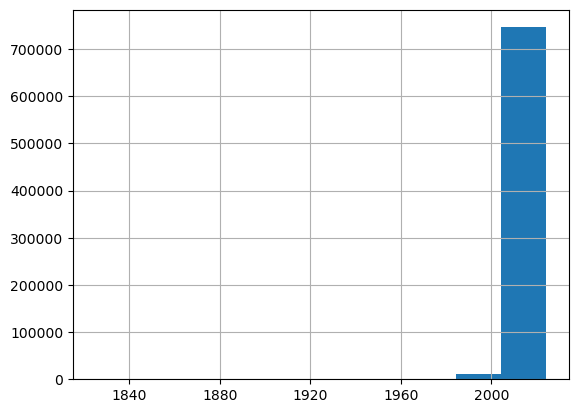

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## संरचित डाटा निकाल्ने

हामीले सारांशहरूबाट सजिलै निकाल्न सकिने जानकारीको प्रकार हेरौं। एउटा चासोको विषय यो हुन सक्छ कि कुन उपचार रणनीतिहरू उपलब्ध छन् र ती समयसँगै कसरी विकसित भए। सुरुमा, हामीले COVID उपचारका लागि प्रयोग गरिने सम्भावित औषधिहरूको सूची र निदानहरूको सूची म्यानुअली तयार गर्न सक्छौं। त्यसपछि, हामी ती सूचीहरूलाई हेर्छौं र कागजहरूको सारांशमा तिनीहरूसँग सम्बन्धित शब्दहरू खोज्छौं।


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


हामीले हाम्रो डेटा फ्रेममा धेरै स्तम्भहरू थपेका छौं जसले कुनै दिइएको औषधि/निदान सारांशमा कति पटक उपस्थित छ भनेर देखाउँछ। 

> **Note** कि हामी उपस्ट्रिङ खोज्दा शब्दको सुरुमा खाली ठाउँ थप्छौं। यदि हामीले यो नगर्ने हो भने, गलत नतिजा आउन सक्छ, किनभने *chloroquine* पनि उपस्ट्रिङ *hydroxychloroquine* भित्र फेला पर्न सक्छ। साथै, हामीले `str` मा सारांश स्तम्भलाई रूपान्तरण गर्न बाध्य पार्छौं ताकि त्रुटि हटाउन सकियोस् - `str` हटाएर के हुन्छ हेर्न प्रयास गर्नुहोस्।

डेटासँग काम गर्न सजिलो बनाउन, हामी केवल औषधिको गणनासहितको उप-फ्रेम निकाल्न सक्छौं, र उपस्थितिको जम्मा संख्या गणना गर्न सक्छौं। यसले हामीलाई सबैभन्दा लोकप्रिय औषधि दिन्छ:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

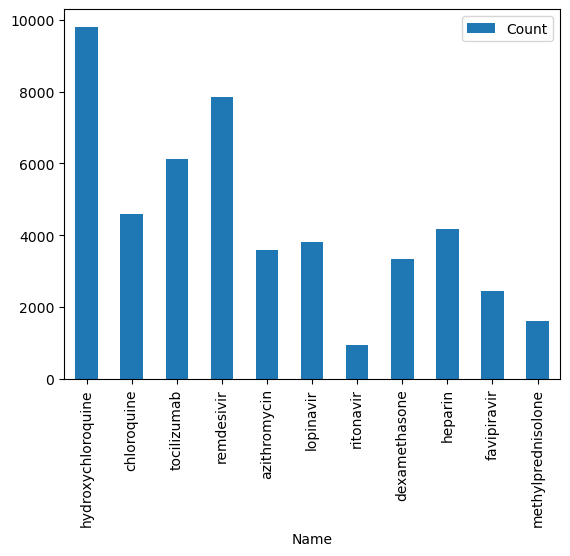

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## उपचार रणनीतिमा प्रवृत्तिहरू खोज्दै

माथिको उदाहरणमा, हामीले सबै मानहरूको `sum` गरेका छौं, तर हामी यो मासिक आधारमा पनि गर्न सक्छौं:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

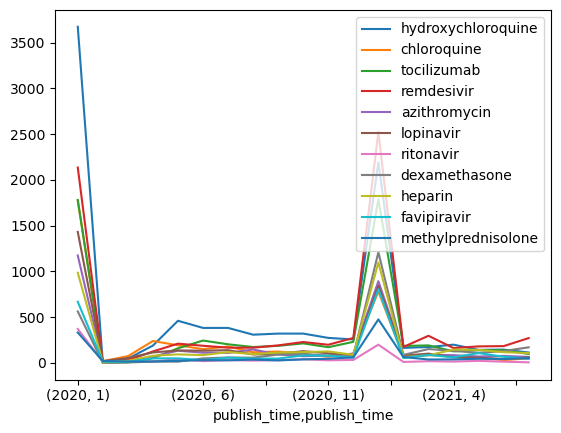

In [152]:
dfmt.plot()
plt.show()

एक रोचक अवलोकन यो हो कि हामीसँग दुई स्थानहरूमा ठूलो वृद्धि देखिन्छ: जनवरी, २०२० र जनवरी, २०२१। यसको कारण के हो भने केही कागजातहरूमा प्रकाशनको मिति स्पष्ट रूपमा निर्दिष्ट गरिएको छैन, र तिनीहरूलाई सम्बन्धित वर्षको जनवरीको रूपमा निर्दिष्ट गरिएको छ।

डाटालाई अझ बुझ्नको लागि, आउनुहोस् केही औषधिहरू मात्र दृश्यात्मक गरौं। हामी जनवरीको डाटा "मेटाउने" छौं, र त्यसलाई केही मध्यम मानले भर्नेछौं, ताकि ग्राफलाई अझ राम्रो देखाउन सकियोस्:


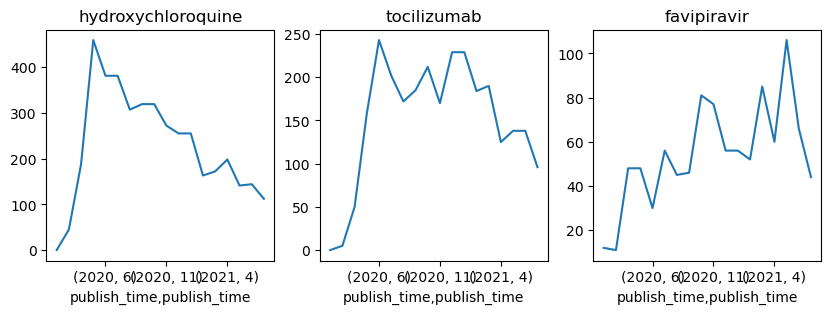

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

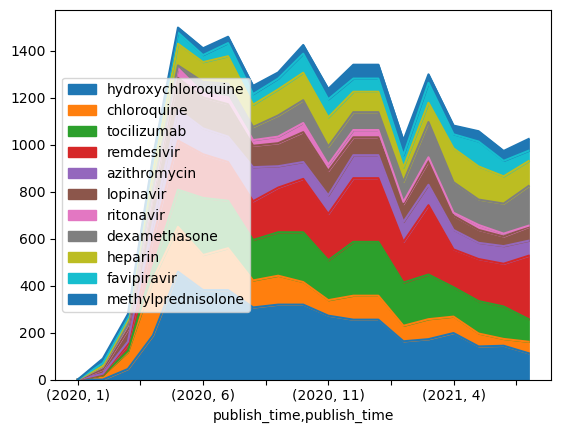

In [154]:
dfmt.plot.area()
plt.show()

झन् अगाडि, हामी प्रतिशतमा सापेक्ष लोकप्रियता गणना गर्न सक्छौं:


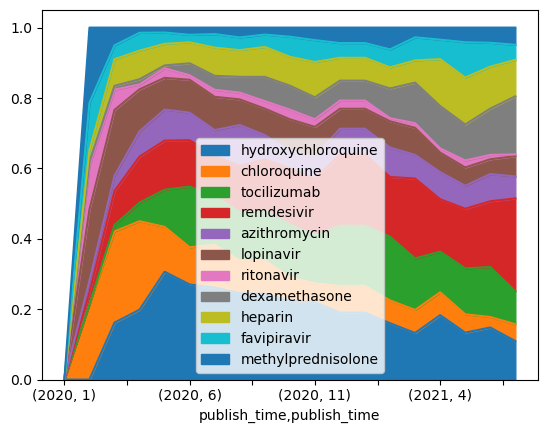

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## औषधि-निदान सम्बन्ध गणना

हामीले खोज्न सक्ने सबैभन्दा रोचक सम्बन्धहरूमध्ये एक हो, विभिन्न निदानहरू कसरी विभिन्न औषधिहरूले उपचार गरिन्छन्। यसलाई दृश्यात्मक बनाउनका लागि, हामीले **सह-उपस्थिति आवृत्ति नक्सा** गणना गर्न आवश्यक छ, जसले देखाउँछ कि दुई शब्दहरू एउटै कागजमा कति पटक उल्लेख गरिएका छन्।

यस्तो नक्सा मूलतः २D म्याट्रिक्स हो, जसलाई **numpy array** द्वारा सबैभन्दा राम्रोसँग प्रतिनिधित्व गर्न सकिन्छ। हामी यो नक्सा सबै सारांशहरूमा हिँडेर, त्यहाँ देखा पर्ने संस्थाहरूलाई चिन्ह लगाएर गणना गर्नेछौं:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

यस म्याट्रिक्सलाई देखाउने तरिकामध्ये एक हो **हिटम्याप** को रूपमा चित्रण गर्नु:


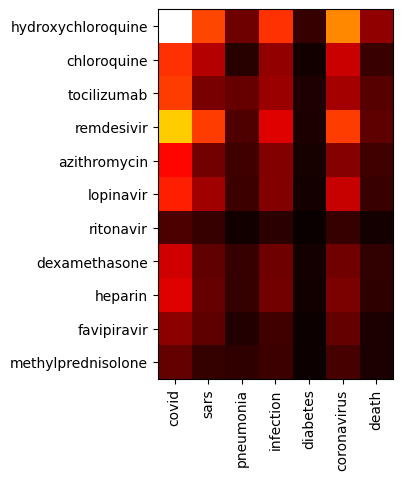

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

तर, अझ राम्रो दृश्यात्मकता **Sankey** डायाग्राम प्रयोग गरेर गर्न सकिन्छ! `matplotlib` मा यो प्रकारको डायाग्रामको लागि बिल्ट-इन समर्थन छैन, त्यसैले हामीले [Plotly](https://plotly.com/python/) प्रयोग गर्नुपर्ने हुन्छ, जसलाई [यस ट्युटोरियल](https://plotly.com/python/sankey-diagram/) मा वर्णन गरिएको छ।

Plotly Sankey डायाग्राम बनाउनका लागि, हामीले निम्न सूचीहरू तयार गर्नुपर्ने हुन्छ:
* ग्राफका सबै नोडहरूको सूची `all_nodes`, जसमा औषधिहरू र निदान (diagnosis) दुवै समावेश हुनेछन्।
* स्रोत (source) र लक्ष्य (target) इन्डेक्सहरूको सूची - यी सूचीहरूले देखाउनेछन् कि कुन नोडहरू डायाग्रामको बायाँतर्फ जान्छन् र कुन दायाँतर्फ।
* सबै लिङ्कहरूको सूची, जसमा प्रत्येक लिङ्कमा निम्न समावेश हुनेछ:
   - `all_nodes` एरेमा स्रोतको इन्डेक्स
   - लक्ष्यको इन्डेक्स
   - लिङ्कको बल (strength) संकेत गर्ने मान। यो ठीक हाम्रो co-occurence म्याट्रिक्सबाट लिइएको मान हो।
   - वैकल्पिक रूपमा, लिङ्कको रङ। स्पष्टताका लागि केही शब्दहरूलाई हाइलाइट गर्न विकल्प दिनेछौं।

Sankey डायाग्राम बनाउनको लागि सामान्य कोडलाई छुट्टै `sankey` फङ्सनको रूपमा संरचना गरिएको छ, जसले दुई सूचीहरू (स्रोत र लक्ष्य कोटीहरू) र co-occurence म्याट्रिक्स लिन्छ। यसले हामीलाई थ्रेसहोल्ड निर्दिष्ट गर्न पनि अनुमति दिन्छ, र ती सबै लिङ्कहरू हटाउन जसको बल उक्त थ्रेसहोल्डभन्दा कमजोर छ - यसले डायाग्रामलाई अलि कम जटिल बनाउँछ।


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## निष्कर्ष

तपाईंले देख्नुभयो कि हामीले गैर-संरचित डाटा स्रोतहरू, जस्तै पाठ, बाट जानकारी निकाल्नका लागि धेरै सरल विधिहरू प्रयोग गर्न सक्छौं। यस उदाहरणमा, हामीले औषधिहरूको विद्यमान सूची लिएका छौं, तर पाठबाट इकाई निकाल्न प्राकृतिक भाषा प्रशोधन (NLP) प्रविधिहरू प्रयोग गर्नु अझ शक्तिशाली हुनेछ। [यस ब्लग पोस्टमा](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) हामीले इकाई निकाल्न क्लाउड सेवाहरू कसरी प्रयोग गर्ने भनेर वर्णन गरेका छौं। अर्को विकल्प भनेको [NLTK](https://www.nltk.org/) जस्ता Python NLP पुस्तकालयहरू प्रयोग गर्नु हो - NLTK प्रयोग गरेर पाठबाट जानकारी निकाल्ने विधि [यहाँ](https://www.nltk.org/book/ch07.html) वर्णन गरिएको छ।


## चुनौती

COVID कागजातका डाटाहरूलाई निम्न बुँदाहरूमा अनुसन्धान गर्न जारी राख्नुहोस्:

1. विभिन्न औषधिहरूको सह-अवस्थिति म्याट्रिक्स तयार गर्नुहोस्, र हेर्नुहोस् कुन औषधिहरू प्रायः सँगै देखा पर्छन् (जस्तै, एउटै सारांशमा उल्लेख गरिएको छ)। औषधि र निदानहरूको लागि सह-अवस्थिति म्याट्रिक्स निर्माण गर्ने कोड परिमार्जन गर्न सक्नुहुन्छ।
1. यो म्याट्रिक्सलाई हीटम्याप प्रयोग गरेर दृश्यात्मक बनाउनुहोस्।
1. थप चुनौतीको रूपमा, औषधिहरूको सह-अवस्थितिलाई [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) प्रयोग गरेर दृश्यात्मक बनाउन प्रयास गर्न सक्नुहुन्छ। [यो पुस्तकालय](https://pypi.org/project/chord/) ले तपाईंलाई chord diagram बनाउन मद्दत गर्न सक्छ।
1. अर्को थप चुनौतीको रूपमा, विभिन्न औषधिहरूको मात्रा (जस्तै, **400mg** मा *प्रत्येक दिन 400mg chloroquine लिनुहोस्*) नियमित अभिव्यक्तिहरू प्रयोग गरेर निकाल्ने प्रयास गर्नुहोस्, र विभिन्न औषधिहरूको लागि विभिन्न मात्राहरू देखाउने dataframe तयार गर्नुहोस्। **नोट**: औषधिको नामको नजिकैको पाठमा रहेका संख्यात्मक मानहरूलाई विचार गर्नुहोस्।



---

**अस्वीकरण**:  
यो दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) प्रयोग गरी अनुवाद गरिएको हो। हामी यथासम्भव सटीकता सुनिश्चित गर्न प्रयास गर्छौं, तर कृपया ध्यान दिनुहोस् कि स्वचालित अनुवादहरूमा त्रुटि वा अशुद्धि हुन सक्छ। यसको मूल भाषामा रहेको मूल दस्तावेज़लाई आधिकारिक स्रोत मानिनुपर्छ। महत्त्वपूर्ण जानकारीका लागि, व्यावसायिक मानव अनुवाद सिफारिस गरिन्छ। यस अनुवादको प्रयोगबाट उत्पन्न हुने कुनै पनि गलतफहमी वा गलत व्याख्याका लागि हामी जिम्मेवार हुने छैनौं।
